In [1]:
%reload_ext autoreload
%autoreload 2

In [118]:
import requests
import pandas as pd
import numpy as np
import statcast

from injury.preprocess.categorization import InjuryCategorizer
from injury.preprocess.injury_events import (
    InjuryEvents,
    add_cols_player_games,
    cum_season_days,
)
from injury.preprocess.injury_map import injury_priority
from injury.preprocess.location_map import location_priority

pd.options.display.max_columns = 100

In [142]:
# injuries

### Injury Categorization & Games

In [165]:
injuries = pd.read_parquet("../data/injuries2012-2022.parquet").sort_values("date")
players = pd.read_parquet("../data/players.parquet").pipe(add_cols_player_games)
season_days = cum_season_days(players[players["game_type"] == "R"])

In [166]:
qualified_players = (
    players[players["game_type"] == "R"]
    .groupby("player_id", as_index=False)
    .size()
    .query("size>=162")["player_id"]
)

In [148]:
len(qualified_players)

1267

In [167]:
inj_cat = InjuryCategorizer()
data = inj_cat.process(injury_data=injuries[injuries.player_id.isin(qualified_players)])

### Games and Injury Length

In [310]:
from injury.preprocess.injury_events import InjuryEvents

In [311]:
players = pd.read_parquet("../data/players.parquet").query("game_type=='R'")
ie = InjuryEvents()

In [312]:
df = ie.process(
    data[data.player_id.isin(qualified_players)],
    players[players.player_id.isin(qualified_players)].drop(columns=["position"]),
)

/Users/Sam/Desktop/Projects/injury/injury/preprocess/injury_events.py:384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"] = (


In [316]:
df = df.merge(players[["player_id", "position"]].drop_duplicates(), how="left")

In [317]:
df.to_parquet("../data/injury_final.parquet")

In [315]:
# df = ie.process(data[data.player_id==656305].query("date>='2017-04-12 '"),
#                 players[players.player_id==656305].drop(columns = ["position"]))

In [225]:
.query("player_id ==  656305 and date>='2017-05-15'")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,il_days,transfer,injury_notes,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t
0,2012-04-28,NaN,NaN,545361.0,NaN,2012,LAA,NaN,Mike Trout,True,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2012-04-28,R,NaN,1.0,NaT,2012-04-28,True,False,1217_10,1217.0,NaN,70.0,NaN,0.0,0.0,2012-04-28,2012-04-28,1,1.0,1,0.0,0,0,0.0,0.0
1,2021-04-23,None,left elbow injury (dtd),545361.0,108.0,2021,LAA,Angels,Mike Trout,True,False,0.0,False,left elbow injury,left elbow injury,misc/unk,left elbow injury,elbow,0,0.0,2021-04-23,NaT,NaN,1.0,1.0,2021-04-22,2021-04-26,False,False,1218_00,1218.0,NaN,0.0,0.0,0.0,70.0,2012-04-28,2012-04-27,1505,0.0,1508,1435.0,3,3,3.0,1435.0
2,2021-05-18,2021-05-18,los angeles angels placed cf mike trout on the...,545361.0,108.0,2021,LAA,Angels,Mike Trout,False,False,10.0,False,right calf strain,right calf strain,tear/strain/sprain,right calf strain,other leg,0,1.0,2021-05-18,NaT,NaN,1.0,0.0,2021-05-17,2022-04-07,False,False,1237_00,1237.0,NaN,0.0,60.0,200.0,0.0,2012-04-28,2021-04-25,1529,1507.0,1530,22.0,1,324,60.0,1457.0
4,2022-04-18,None,left hand injury (dtd),545361.0,108.0,2022,LAA,Angels,Mike Trout,True,False,0.0,False,left hand injury,left hand injury,misc/unk,left hand injury,hand,0,7.0,2022-04-18,NaT,NaN,1.0,1.0,2022-04-17,2022-04-22,False,False,1246_00,1246.0,NaN,0.0,0.0,0.0,0.0,2012-04-28,2022-04-11,1541,1534.0,1545,12.0,4,4,4.0,1469.0
5,2022-06-08,None,left groin injury (dtd),545361.0,108.0,2022,LAA,Angels,Mike Trout,True,False,0.0,False,left groin injury,left groin injury,misc/unk,left groin injury,hip,0,8.0,2022-06-08,NaT,NaN,1.0,1.0,2022-06-07,2022-06-11,False,False,1287_00,1287.0,NaN,0.0,0.0,0.0,0.0,2012-04-28,2022-04-21,1592,1544.0,1595,48.0,3,3,3.0,1517.0
6,2022-07-13,None,back spasms (dtd),545361.0,108.0,2022,LAA,Angels,Mike Trout,True,False,0.0,False,back spasms,back spasms,minor,back spasms,back,0,9.0,2022-07-13,NaT,NaN,1.0,1.0,2022-07-12,2022-08-19,False,False,1313_00,1313.0,NaN,0.0,0.0,0.0,0.0,2012-04-28,2022-06-10,1627,1594.0,1664,33.0,37,37,37.0,1550.0
7,2022-09-10,NaN,NaN,545361.0,NaN,2022,LAA,NaN,Mike Trout,True,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2022-09-10,R,1.0,NaN,2022-09-09,2022-09-10,False,True,1314_01,1314.0,1.0,0.0,NaN,0.0,0.0,2012-04-28,2022-08-18,1686,1663.0,1686,23.0,0,0,0.0,1573.0


In [213]:
# data[["injury_location","injury_type"]].max(axis = 0)

In [313]:
test = (
    old_df[["date", "player_id", "name", "injury_location"]]
    .merge(
        df[["date", "player_id", "injury_location"]],
        how="left",
        on=["date", "player_id"],
    )
    .query("injury_location_x!=injury_location_y")
)

In [314]:
test

,date,player_id,name,injury_location_x,injury_location_y
556,2013-05-14,425786.0,Scott Atchison,elbow,hip
750,2012-04-04,430661.0,Dustin McGowan,shoulder,foot
768,2014-04-14,430895.0,Maicer Izturis,knee,hip
843,2016-05-28,431151.0,David Wright,shoulder,back
1018,2018-05-20,435062.0,Howie Kendrick,hamstring,ankle
...,...,...,...,...,...
8541,2018-04-28,624577.0,Yasiel Puig,foot,hip
8565,2022-06-29,624585.0,Jorge Soler,back,hip
8585,2021-08-23,628317.0,Kenta Maeda,elbow,other arm
8805,2019-08-01,641933.0,Tyler O'Neill,hand,wrist


In [279]:
old_df.query("player_id == 656305 and date>='2017-05-15'")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,il_days,transfer,injury_notes,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t
9559,2017-06-15,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,True,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2017-06-15,R,NaN,1.0,NaT,2017-06-15,True,False,3_10,3.0,NaN,0.0,NaN,0.0,0.0,2017-06-15,2017-06-15,1006.0,1006.0,1006.0,0.0,0.0,0.0,0.0,0.0
9560,2017-06-19,None,left knee injury (dtd),656305.0,133.0,2017,OAK,Athletics,Matt Chapman,False,False,0.0,False,left knee injury,left knee injury,misc/unk,left knee injury,knee,0,0.0,2017-06-19,NaT,NaN,1.0,0.0,2017-06-18,2017-07-03,False,False,4_00,4.0,NaN,0.0,10.0,10.0,0.0,2017-06-15,2017-06-14,1010.0,1005.0,1024.0,5.0,14.0,14.0,14.0,5.0
9561,2018-06-15,None,right hand injury (dtd),656305.0,133.0,2018,OAK,Athletics,Matt Chapman,False,False,0.0,False,right hand injury,right hand injury,contusion/bruise,right hand injury,hand,0,2.0,2018-06-15,NaT,NaN,1.0,0.0,2018-06-14,2018-07-03,False,False,151_00,151.0,NaN,0.0,10.0,10.0,0.0,2017-06-15,2017-07-02,1193.0,1023.0,1211.0,170.0,18.0,18.0,18.0,175.0
9562,2019-07-18,None,ankle injury (dtd),656305.0,133.0,2019,OAK,Athletics,Matt Chapman,True,False,0.0,False,ankle injury,ankle injury,misc/unk,ankle injury,ankle,0,4.0,2019-07-18,NaT,NaN,1.0,1.0,2019-07-17,2019-07-20,False,False,319_00,319.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2018-07-02,1422.0,1210.0,1424.0,212.0,2.0,2.0,2.0,387.0
9563,2020-09-07,None,right hip injury (dtd),656305.0,133.0,2020,OAK,Athletics,Matt Chapman,False,False,0.0,False,right hip injury,right hip injury,tear/strain/sprain,right hip injury,hip,0,5.0,2020-09-07,NaT,NaN,1.0,0.0,2020-09-06,2021-04-01,False,False,414_00,414.0,NaN,0.0,10.0,10.0,0.0,2017-06-15,2019-07-19,1542.0,1423.0,1563.0,119.0,21.0,206.0,21.0,506.0
9565,2021-08-23,None,left foot injury (dtd),656305.0,133.0,2021,OAK,Athletics,Matt Chapman,True,False,0.0,False,left foot injury,left foot injury,misc/unk,left foot injury,foot,0,8.0,2021-08-23,NaT,NaN,1.0,1.0,2021-08-22,2021-08-24,False,False,534_00,534.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-07-07,1707.0,1660.0,1708.0,145.0,1.0,1.0,1.0,651.0
9566,2021-09-12,None,lower leg injury (dtd),656305.0,133.0,2021,OAK,Athletics,Matt Chapman,True,False,0.0,False,lower leg injury,lower leg injury,misc/unk,lower leg injury,other leg,0,9.0,2021-09-12,NaT,NaN,1.0,1.0,2021-09-11,2021-09-17,False,False,550_00,550.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-08-23,1727.0,1707.0,1732.0,20.0,5.0,5.0,5.0,671.0
9567,2022-06-11,None,wrist injury (dtd),656305.0,141.0,2022,TOR,Blue Jays,Matt Chapman,True,False,0.0,False,wrist injury,wrist injury,misc/unk,wrist injury,wrist,0,10.0,2022-06-11,NaT,NaN,1.0,1.0,2022-06-10,2022-06-14,False,False,619_00,619.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-09-16,1814.0,1731.0,1817.0,83.0,3.0,3.0,3.0,754.0
9568,2022-06-16,None,sore right wrist (dtd),656305.0,141.0,2022,TOR,Blue Jays,Matt Chapman,True,False,0.0,False,sore right wrist,soreness right wrist,minor,sore right wrist,wrist,0,11.0,2022-06-16,NaT,NaN,1.0,1.0,2022-06-15,2022-06-17,False,False,621_00,621.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2022-06-13,1819.0,1816.0,1820.0,3.0,1.0,1.0,1.0,757.0
9569,2022-09-10,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,True,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2022-09-10,R,1.0,NaN,2022-09-09,2022-09-10,False,True,1500_01,1500.0,1.0,0.0,NaN,0.0,0.0,2017-06-15,2022-06-16,1905.0,1819.0,1905.0,86.0,0.0,0.0,0.0,843.0


In [286]:
df_before.query("player_id ==  656305 and date>='2017-05-15'")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,il_days,transfer,injury_notes,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days
310592,2017-06-15,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2017-06-15,R,NaN,1.0,NaT,2017-06-15,True,False,3_10,3.0,NaN,NaN
310655,2017-06-16,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2017-06-16,R,1.0,1.0,2017-06-15,2017-06-16,False,False,3_00,3.0,1.0,0.0
311210,2017-06-17,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2017-06-17,R,1.0,1.0,2017-06-16,2017-06-17,False,False,3_00,3.0,1.0,0.0
311680,2017-06-18,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2017-06-18,R,1.0,0.0,2017-06-17,2017-06-18,False,False,3_00,3.0,1.0,0.0
312040,2017-06-19,None,left knee injury (dtd),656305.0,133.0,2017,OAK,Athletics,Matt Chapman,True,False,0.0,False,left knee injury,left knee injury,misc/unk,left knee injury,knee,0,0.0,2017-06-19,NaT,NaN,1.0,0.0,2017-06-18,2017-07-03,False,False,4_00,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578300,2022-09-05,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2022-09-05,R,1.0,1.0,2022-09-04,2022-09-05,False,False,1500_00,1500.0,1.0,0.0
578370,2022-09-06,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2022-09-06,R,1.0,1.0,2022-09-05,2022-09-06,False,False,1500_00,1500.0,1.0,0.0
578802,2022-09-07,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2022-09-07,R,1.0,1.0,2022-09-06,2022-09-07,False,False,1500_00,1500.0,1.0,0.0
579014,2022-09-09,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2022-09-09,R,1.0,1.0,2022-09-07,2022-09-09,False,False,1500_00,1500.0,2.0,0.0


In [281]:
df.query("player_id ==  656305 and date>='2017-05-15'")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,il_days,transfer,injury_notes,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t
9559,2017-06-15,NaN,NaN,656305.0,NaN,2017,OAK,NaN,Matt Chapman,True,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2017-06-15,R,NaN,1.0,NaT,2017-06-15,True,False,3_10,3.0,NaN,0.0,NaN,0.0,0.0,2017-06-15,2017-06-15,1006.0,1006.0,1006.0,0.0,0.0,0.0,0.0,0.0
9561,2018-06-15,None,right hand injury (dtd),656305.0,133.0,2018,OAK,Athletics,Matt Chapman,False,False,0.0,False,right hand injury,right hand injury,contusion/bruise,right hand injury,hand,0,2.0,2018-06-15,NaT,NaN,1.0,0.0,2018-06-14,2018-07-03,False,False,151_00,151.0,NaN,0.0,10.0,10.0,0.0,2017-06-15,2017-07-02,1193.0,1023.0,1211.0,175.0,18.0,18.0,18.0,175.0
9562,2019-07-18,None,ankle injury (dtd),656305.0,133.0,2019,OAK,Athletics,Matt Chapman,True,False,0.0,False,ankle injury,ankle injury,misc/unk,ankle injury,ankle,0,4.0,2019-07-18,NaT,NaN,1.0,1.0,2019-07-17,2019-07-20,False,False,319_00,319.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2018-07-02,1422.0,1210.0,1424.0,212.0,2.0,2.0,2.0,387.0
9563,2020-09-07,None,right hip injury (dtd),656305.0,133.0,2020,OAK,Athletics,Matt Chapman,False,False,0.0,False,right hip injury,right hip injury,tear/strain/sprain,right hip injury,hip,0,5.0,2020-09-07,NaT,NaN,1.0,0.0,2020-09-06,2021-04-01,False,False,414_00,414.0,NaN,0.0,10.0,10.0,0.0,2017-06-15,2019-07-19,1542.0,1423.0,1563.0,119.0,21.0,206.0,21.0,506.0
9565,2021-08-23,None,left foot injury (dtd),656305.0,133.0,2021,OAK,Athletics,Matt Chapman,True,False,0.0,False,left foot injury,left foot injury,misc/unk,left foot injury,foot,0,8.0,2021-08-23,NaT,NaN,1.0,1.0,2021-08-22,2021-08-24,False,False,534_00,534.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-07-07,1707.0,1660.0,1708.0,145.0,1.0,1.0,1.0,651.0
9566,2021-09-12,None,lower leg injury (dtd),656305.0,133.0,2021,OAK,Athletics,Matt Chapman,True,False,0.0,False,lower leg injury,lower leg injury,misc/unk,lower leg injury,other leg,0,9.0,2021-09-12,NaT,NaN,1.0,1.0,2021-09-11,2021-09-17,False,False,550_00,550.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-08-23,1727.0,1707.0,1732.0,20.0,5.0,5.0,5.0,671.0
9567,2022-06-11,None,wrist injury (dtd),656305.0,141.0,2022,TOR,Blue Jays,Matt Chapman,True,False,0.0,False,wrist injury,wrist injury,misc/unk,wrist injury,wrist,0,10.0,2022-06-11,NaT,NaN,1.0,1.0,2022-06-10,2022-06-14,False,False,619_00,619.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2021-09-16,1814.0,1731.0,1817.0,83.0,3.0,3.0,3.0,754.0
9568,2022-06-16,None,sore right wrist (dtd),656305.0,141.0,2022,TOR,Blue Jays,Matt Chapman,True,False,0.0,False,sore right wrist,soreness right wrist,minor,sore right wrist,wrist,0,11.0,2022-06-16,NaT,NaN,1.0,1.0,2022-06-15,2022-06-17,False,False,621_00,621.0,NaN,0.0,0.0,0.0,0.0,2017-06-15,2022-06-13,1819.0,1816.0,1820.0,3.0,1.0,1.0,1.0,757.0
9569,2022-09-10,NaN,NaN,656305.0,NaN,2022,TOR,NaN,Matt Chapman,True,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2022-09-10,R,1.0,NaN,2022-09-09,2022-09-10,False,True,1500_01,1500.0,1.0,0.0,NaN,0.0,0.0,2017-06-15,2022-06-16,1905.0,1819.0,1905.0,86.0,0.0,0.0,0.0,843.0


In [502]:
# players.query("player_id == 592178 ")

In [511]:
df[df.prev_non_mlb_days == 100]

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t
1798,2015-05-24,NaN,hamstring injury (dtd),446263.0,121.0,2015,NYM,Mets,Lucas Duda,True,False,False,hamstring injury,NaN,hamstring injury,misc/unk,hamstring injury,hamstring,0,0.0,2015-05-24,NaT,NaN,1.0,1.0,2015-05-23,2015-05-25,False,False,412_00,412.0,NaN,0.0,NaN,0.0,100.0,2012-04-05,2012-04-04,615.0,8.0,616.0,507.0,1.0,1.0,1.0,507.0
2456,2014-03-27,2014-03-21,boston red sox placed rhp steven wright on the...,453214.0,111.0,2014,BOS,Red Sox,Steven Wright,False,False,False,recovering from january 2014 right sports hern...,15.0,recovering from january 2014 right sports hern...,surgery,recovering from january 2014 right sports hern...,misc/unk,0,0.0,2014-03-27,NaT,NaN,1.0,1.0,2013-08-06,2014-08-17,False,False,4_00,4.0,NaN,0.0,15.0,15.0,100.0,2013-04-23,2013-04-22,380.0,213.0,523.0,67.0,143.0,143.0,143.0,67.0
3896,2017-02-16,2017-02-16,atlanta braves placed rhp chaz roe on the 10-d...,475054.0,144.0,2017,ATL,Braves,Chaz Roe,False,False,False,,10.0,,misc/unk,,misc/unk,0,1.0,2017-02-16,NaT,NaN,1.0,1.0,2016-10-01,2017-04-03,False,False,90_00,90.0,NaN,0.0,10.0,10.0,100.0,2013-07-01,2015-09-01,931.0,715.0,933.0,116.0,2.0,46.0,10.0,250.0
4845,2021-07-18,NaN,discomfort in right shoulder (dtd),502202.0,158.0,2021,MIL,Brewers,Brad Boxberger,True,False,False,discomfort in right shoulder,NaN,discomfort in right shoulder,minor,discomfort in right shoulder,shoulder,0,4.0,2021-07-18,NaT,NaN,1.0,1.0,2021-07-17,2021-07-23,False,False,385_00,385.0,NaN,0.0,NaN,0.0,100.0,2012-06-10,2017-06-29,1671.0,1020.0,1676.0,551.0,5.0,5.0,5.0,1094.0
6006,2016-07-07,NaN,elbow injury (dtd),527055.0,144.0,2016,ATL,Braves,Arodys Vizcaino,True,False,False,elbow injury,NaN,elbow injury,misc/unk,elbow injury,elbow,0,1.0,2016-07-07,NaT,NaN,1.0,1.0,2016-07-06,2016-07-15,False,False,79_00,79.0,NaN,0.0,NaN,0.0,100.0,2013-03-27,2014-09-05,844.0,542.0,852.0,202.0,8.0,8.0,8.0,202.0
6623,2019-04-09,NaN,NaN,543484.0,NaN,2019,DET,NaN,Mikie Mahtook,NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2019-04-09,R,1.0,NaN,2019-04-06,2019-04-09,False,True,1461_01,1461.0,3.0,100.0,NaN,0.0,100.0,2015-04-10,2017-09-14,1322.0,1097.0,1322.0,125.0,0.0,0.0,0.0,426.0
7267,2015-09-14,NaN,hamstring injury (dtd),553988.0,116.0,2015,DET,Tigers,Dixon Machado,True,False,False,hamstring injury,NaN,hamstring injury,misc/unk,hamstring injury,hamstring,0,0.0,2015-09-14,NaT,NaN,1.0,1.0,2015-09-13,2015-09-18,False,False,9_00,9.0,NaN,0.0,NaN,0.0,100.0,2015-05-25,2015-05-24,728.0,615.0,732.0,13.0,4.0,4.0,4.0,13.0
8074,2018-03-29,2018-03-26,colorado rockies placed lhp zac rosscup on the...,573127.0,115.0,2018,COL,Rockies,Zac Rosscup,False,False,False,left middle finger blister,10.0,left middle finger blister,minor,left middle hand blister,hand,0,2.0,2018-03-29,NaT,NaN,1.0,1.0,2017-09-20,2018-07-20,False,False,71_00,71.0,NaN,0.0,10.0,10.0,100.0,2013-09-03,2017-05-21,1115.0,981.0,1228.0,34.0,113.0,113.0,113.0,239.0
9401,2018-09-16,NaN,sore lower back (dtd),600303.0,112.0,2018,CHC,Cubs,Tommy La Stella,True,False,False,sore lower back,NaN,soreness lower back,minor,sore lower back,back,0,3.0,2018-09-16,NaT,NaN,1.0,1.0,2018-09-14,2018-09-24,False,False,380_00,380.0,NaN,0.0,NaN,0.0,100.0,2014-05-28,2016-07-05,1286.0,842.0,1294.0,344.0,8.0,8.0,8.0,587.0
9763,2018-07-23,2018-07-20,tampa bay rays placed lhp blake snell on the 1...,605483.0,139.0,2018,TB,Rays,Blake Snell,False,False,False,left shoulder fatigue,10.0,left shoulder fatigue,minor,left shoulder fatigue

In [571]:
# df.query("dt==1 and player_last_row and not player_first_row")

In [324]:
from injury.preprocess.injury_map import (
    alt_injury_regex,
    injury_cat,
    injury_large_cat_map,
    injury_priority,
)
from injury.preprocess.location_map import (
    alt_location_regex,
    location_cat,
    location_large_cat_map,
    location_priority,
)
from injury.preprocess.categorization import injury_priority_map

data["location_len"] = data.groupby(["player_id", "injury_span_id"])[
    "injury_location"
].transform(len)
# df["type_len"] = df.groupby(["player_id","injury_span_id"])["injury_type"].transform(len)
# df["test"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform(max)
# df["test_type"] = df.groupby(["player_id","injury_span_id"])["injury_type"].transform(max)
# df["mean_dtd"] = df.groupby(["player_id","injury_span_id"])["dtd"].transform(np.mean)
# df["location_same"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform("nunique")

# df["location_unk"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform(lambda x: sum(x=='misc/unk'))

In [332]:
# data.query("location_len>1 and game==0").sort_values(["player_id","date"])

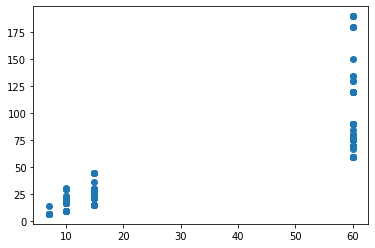

In [335]:
plt.scatter(df.il_days_max, df.il_days_sum)

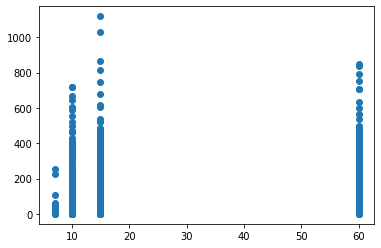

In [336]:
plt.scatter(df.il_days_max, df.in_season_duration)

In [21]:
data.query("player_id==542585")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location
619,2014-05-09,2014-05-07,houston astros placed rhp jose cisnero on the ...,542585.0,117.0,2014,HOU,Astros,Jose Cisnero,False,False,False,right elbow discomfort,15.0,right elbow discomfort,minor,right elbow discomfort,elbow
7793,2021-09-14,2021-09-13,detroit tigers placed rhp jose cisnero on the ...,542585.0,116.0,2021,DET,Tigers,Jose Cisnero,False,False,False,right elbow laceration,10.0,right elbow laceration,minor,right elbow laceration,elbow
7959,2022-04-06,2022-04-06,detroit tigers placed rhp jose cisnero on the ...,542585.0,116.0,2022,DET,Tigers,Jose Cisnero,False,False,False,right shoulder strain,60.0,right shoulder strain,tear/strain/sprain,right shoulder strain,shoulder


In [20]:
df.sort_values("duration").query("game==0").tail(50).tail(20)

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t,injury_length,next_location,time_to_next,next_type
871,2016-05-28,NaN,neck injury (dtd),431151.0,121.0,2016,NYM,Mets,David Wright,True,False,False,neck injury,NaN,neck injury,misc/unk,head/neck injury,shoulder,0,4.0,2016-05-28,NaT,NaN,1.0,0.0,2016-05-27,2018-09-28,False,False,472_00,472.0,NaN,0.0,15.0,35.0,0.0,2012-04-05,2016-05-17,804.0,793.0,1298.0,11.0,494.0,853.0,494.0,597.0,long,[END],2.0,[END]
493,2012-04-04,2012-04-04,cincinnati reds placed rhp ryan madson on the ...,425492.0,113.0,2012,CIN,Reds,Ryan Madson,False,False,False,recovering from april 2012 tommy john surgery,60.0,recovering from april 2012 tommy john surgery,surgery,recovering from april 2012 elbow surgery,elbow,0,0.0,2012-04-04,NaT,NaN,NaN,0.0,NaT,2015-04-06,True,False,0_10,0.0,NaN,0.0,60.0,75.0,0.0,2012-04-04,2012-04-04,8.0,8.0,567.0,0.0,559.0,1097.0,559.0,0.0,long,other arm,140.0,misc/unk
3535,2017-08-19,2017-08-14,kansas city royals placed rhp neftali feliz on...,491703.0,118.0,2017,KC,Royals,Neftali Feliz,False,False,False,right ulnar nerve palsy,10.0,right ulnar nerve palsy,misc/unk,right elbow nerve palsy,elbow,0,3.0,2017-08-19,NaT,NaN,1.0,1.0,2017-08-13,2021-06-28,False,False,202_00,202.0,NaN,0.0,10.0,10.0,33.0,2012-04-10,2015-07-02,1071.0,654.0,1651.0,541.0,580.0,1409.0,580.0,583.0,long,[END],4.0,[END]
4948,2015-04-05,2015-04-05,kansas city royals placed lhp tim collins on t...,525768.0,118.0,2015,KC,Royals,Tim Collins,False,False,False,recovering from march 2015 tommy john surgery,15.0,recovering from march 2015 tommy john surgery,surgery,recovering from march 2015 elbow surgery,elbow,0,1.0,2015-04-05,NaT,NaN,1.0,0.0,2014-09-28,2018-05-21,False,False,160_00,160.0,NaN,0.0,60.0,75.0,95.0,2012-04-07,2014-05-03,566.0,417.0,1168.0,54.0,602.0,1142.0,602.0,435.0,long,[END],106.0,[END]
4032,2015-07-17,2015-07-12,washington nationals placed rhp david carpente...,502304.0,120.0,2015,WSH,Nationals,David Carpenter,False,False,False,right shoulder inflammation,15.0,right shoulder inflammationmation,inflammation,right shoulder inflammation,shoulder,0,1.0,2015-07-17,NaT,NaN,1.0,1.0,2015-07-05,2019-06-04,False,False,184_00,184.0,NaN,0.0,15.0,15.0,0.0,2012-04-09,2014-07-07,669.0,482.0,1378.0,187.0,709.0,1418.0,709.0,494.0,long,[END],6.0,[END]
4331,2014-03-29,2014-03-21,los angeles angels placed rhp ryan brasier on ...,518489.0,108.0,2014,LAA,Angels,Ryan Brasier,False,False,False,right elbow strain,15.0,right elbow strain,tear/strain/sprain,right elbow strain,elbow,0,0.0,2014-03-29,NaT,NaN,1.0,1.0,2013-09-27,2018-07-09,False,False,7_00,7.0,NaN,0.0,15.0,15.0,120.0,2013-05-02,2013-05-01,382.0,222.0,1217.0,40.0,835.0,1563.0,835.0,40.0,long,foot,51.0,misc/unk
5130,2014-05-09,2014-05-07,houston astros placed rhp jose cisnero on the ...,542585.0,117.0,2014,HOU,Astros,Jose Cisnero,False,False,False,right elbow discomfort,15.0,right elbow discomfort,minor,right elbow discomfort,elbow,0,0.0,2014-05-09,NaT,NaN,1.0,1.0,2014-05-06,2019-06-23,False,False,33_00,33.0,NaN,0.0,15.0,15.0,90.0,2013-04-22,2013-04-21,423.0,212.0,1397.0,121.0,974.0,1871.0,974.0,121.0,long,shoulder,333.0,tear/strain/sprain
201,2019-10-04,NaN,shoulder injury (dtd),282332.0,147.0,2019,NYY,Yankees,CC Sabathia,True,False,False,shoulder injury,NaN,shoulder injury,misc/unk,shoulder injury,shoulder,0,16.0,2019-10-04,NaT,NaN,1.0,NaN,2019-09-24,NaT,False,True,206_01,206.0,NaN,0.0,NaN,0.0,0.0,2012-04-06,2019-09-11,1495.0,1477.0,NaN,18.0,NaN,NaN,NaN,1172.0,NaN,NaN,

In [11]:
# df["duration"] = df.groupby(["injury_location","injury_type"])["duration"].transform("median")

# df["injury_length"] = pd.cut(df.duration, bins = [0,10,4*7, np.inf], labels=["short","med","long"])
df["injury_length"] = pd.cut(
    df.duration, bins=[-1, 15, np.inf], labels=["short", "long"]
)
df["next_location"] = df.groupby("player_id")["injury_location"].shift(-1)
df["time_to_next"] = df.groupby("player_id")["dt"].shift(-1)
df["next_type"] = df.groupby("player_id")["injury_type"].shift(-1)
# np.where(df.dtd, "dtd", pd.cut(df.in_season_duration, bins = [0,10,6*7, np.inf]))

In [27]:
df["location_duration"] = (
    df["injury_location"].astype(str) + "_" + df["injury_length"].astype(str)
)
df["next_location_duration"] = df.groupby("player_id")["location_duration"].shift(-1)

df["type_duration"] = (
    df["injury_type"].astype(str) + "_" + df["injury_length"].astype(str)
)
df["next_type_duration"] = df.groupby("player_id")["type_duration"].shift(-1)

df["location_type"] = (
    df["injury_location"].astype(str) + "_" + df["injury_type"].astype(str)
)
df["next_location_type"] = df.groupby("player_id")["location_type"].shift(-1)

In [601]:
# df.merge(qualified_players.query("size>100"))\
#                         .query("location_duration!='[STAZRT]_nan' and next_location_duration!='[END]_nan'")\
#             .groupby(["location_duration","next_location_duration"], as_index = False)\
#             .size().sort_values("size")

In [612]:
# df["injury_type"]

In [602]:
df.query(
    "location_duration!='[START]_nan' and next_location_duration!='[END]_nan'"
).groupby(
    ["location_duration", "next_location_duration"], as_index=False
).size().sort_values(
    "size"
)

,location_duration,next_location_duration,size
412,head/neck_long,other arm_short,1
599,misc/unk_long,shoulder_nan,1
603,misc/unk_long,wrist_long,1
890,wrist_long,head/neck_nan,1
703,other leg_long,elbow_short,1
...,...,...,...
28,[START]_short,torso_long,106
757,shoulder_long,[END]_short,111
5,[START]_short,elbow_long,125
26,[START]_short,shoulder_long,173


In [31]:
df.query("injury_location=='[START]'").next_location.value_counts(
    normalize=True
) / df.query("injury_location!='[START]'").next_location.value_counts(normalize=True)

[END]        0.969604
ankle        1.029887
back         0.743648
elbow        1.514650
foot         0.678589
hamstring    0.767790
hand         1.050558
head/neck    1.063250
hip          0.762696
knee         0.822619
misc/unk     0.963025
other arm    1.423924
other leg    0.604858
shoulder     1.520457
torso        1.335731
wrist        0.845346
Name: next_location, dtype: float64

In [30]:
df.query("injury_location!='[START]'").next_location.value_counts(normalize=True)

[END]        0.162547
back         0.081153
hamstring    0.080550
shoulder     0.077415
hand         0.075485
misc/unk     0.071988
knee         0.064874
other leg    0.056071
torso        0.054142
elbow        0.051369
hip          0.051007
head/neck    0.042687
other arm    0.036778
wrist        0.033040
foot         0.030869
ankle        0.030025
Name: next_location, dtype: float64

In [634]:
df[df.location_duration.str.contains("back")]

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,injury_span_id_orig,time_since_last_game,non_mlb_days,il_days_max,il_days_sum,prev_non_mlb_days,start_date,prev_injury_end_date,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,date_duration,duration,t,injury_length,next_location,next_type,time_to_next,location_duration,next_location_duration,type_duration,next_type_duration,location_type,next_location_type
12,2018-08-19,NaN,back injury (dtd),112526.0,140.0,2018,TEX,Rangers,Bartolo Colon,True,False,False,back injury,NaN,back injury,misc/unk,back injury,back,0,3.0,2018-08-19,NaT,NaN,1.0,1.0,2018-08-13,2018-08-20,False,False,204_00,204.0,NaN,0.0,NaN,0.0,20.0,2012-03-29,2017-06-27,1258.0,1018.0,1259.0,220.0,1.0,1.0,1.0,1143.0,short,back,tear/strain/sprain,5.0,back_short,back_short,misc/unk_short,tear/strain/sprain_short,back_misc/unk,back_tear/strain/sprain
13,2018-08-24,2018-08-21,texas rangers placed rhp bartolo colon on the ...,112526.0,140.0,2018,TEX,Rangers,Bartolo Colon,False,False,False,lower back strain,10.0,lower back strain,tear/strain/sprain,lower back strain,back,0,4.0,2018-08-24,NaT,NaN,1.0,0.0,2018-08-20,2018-09-05,False,False,205_00,205.0,NaN,0.0,10.0,10.0,0.0,2012-03-29,2018-08-19,1263.0,1258.0,1275.0,5.0,12.0,12.0,12.0,1148.0,short,[END],[END],18.0,back_short,[END]_short,tear/strain/sprain_short,[END]_short,back_tear/strain/sprain,[END]_[END]
49,2013-07-03,2013-07-03,chicago white sox placed 1b paul konerko on th...,117244.0,145.0,2013,CWS,White Sox,Paul Konerko,False,False,False,lower back strain,15.0,lower back strain,tear/strain/sprain,lower back strain,back,0,1.0,2013-07-03,NaT,NaN,1.0,1.0,2013-07-02,2013-07-22,False,False,210_00,210.0,NaN,0.0,15.0,15.0,0.0,2012-04-06,2012-08-16,285.0,142.0,304.0,143.0,19.0,19.0,19.0,270.0,long,[END],[END],245.0,back_long,[END]_short,tear/strain/sprain_long,[END]_short,back_tear/strain/sprain,[END]_[END]
52,2012-05-19,2012-05-13,san diego padres placed rf mark kotsay on the ...,117276.0,135.0,2012,SD,Padres,Mark Kotsay,False,False,False,lower back strain,15.0,lower back strain,tear/strain/sprain,lower back strain,back,0,1.0,2012-05-19,NaT,NaN,1.0,1.0,2012-05-12,2012-06-03,False,False,18_00,18.0,NaN,0.0,15.0,15.0,0.0,2012-04-03,2012-04-16,53.0,20.0,68.0,33.0,15.0,15.0,15.0,33.0,short,[END],[END],306.0,back_short,[END]_short,tear/strain/sprain_short,[END]_short,back_tear/strain/sprain,[END]_[END]
78,2012-06-18,2012-06-16,chicago cubs placed rhp ryan dempster on the 1...,133225.0,112.0,2012,CHC,Cubs,Ryan Dempster,False,False,False,tight right lat,15.0,tightnesst right lat,minor,tight right back,back,0,1.0,2012-06-18,NaT,NaN,1.0,1.0,2012-06-15,2012-07-08,False,False,12_00,12.0,NaN,0.0,15.0,15.0,0.0,2012-04-05,2012-05-02,83.0,36.0,103.0,47.0,20.0,20.0,20.0,64.0,long,[END],[END],271.0,back_long,[END]_short,minor_long,[END]_short,back_minor,[END]_[END]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12740,2022-05-25,2022-05-22,miami marlins placed rhp anthony bender on the...,669622.0,146.0,2022,MIA,Marlins,Anthony Bender,False,False,False,back stiffness,15.0,back stiffness,minor,back stiffness,back,0,1.0,2022-05-25,NaT,NaN,1.0,NaN,2022-05-18,NaT,False,True,77_01,77.0,NaN,0.0,15.0,15.0,0.0,2021-05-05,2022-04-25,1797.0,1767.0,NaN,30.0,NaN,NaN,15.0,197.0,short,NaN,NaN,NaN,back_short,NaN,minor_short,NaN,back_minor,NaN
12758,2022-06-28,NaN,lower back injury (dtd),670280.0,134.0,2022,PIT,Pirates,David Bednar,True,False,False,lower back injury,NaN,lower back injury,misc/unk,lower back injury,back,0,1.0,2022-0

In [627]:
# mat = pd.pivot_table(df[df.location_duration.notnull()  ]

#                      # .merge(qualified_players.query("size>100"))\
#                     .query("injury_location!='[START]' and next_location!='[END]' and injury_location!='[END]'")\
#             .groupby(["injury_type","next_type"], as_index = False)\
#             .size(),
#                      columns="next_type",
#               values = "size",
#               index = "injury_type").fillna(0)

# mat = mat.drop(columns = ["misc/unk"], index = ["misc/unk"])
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize = (20,10))
# sns.heatmap(mat/mat.sum(1).values.reshape(-1,1))

In [626]:
# mat = pd.pivot_table(df[df.location_duration.notnull() ]

#                      # .merge(qualified_players.query("size>100"))\
#                     .query("injury_location!='[START]' and next_location!='[END]' and injury_location!='[END]'")\
#             .groupby(["type_duration","next_type_duration"], as_index = False)\
#             .size(),
#                      columns="next_type_duration",
#               values = "size",
#               index = "type_duration").fillna(0)

# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize = (20,10))
# sns.heatmap(mat/mat.sum(1).values.reshape(-1,1))

<AxesSubplot:xlabel='next_location_duration', ylabel='location_duration'>

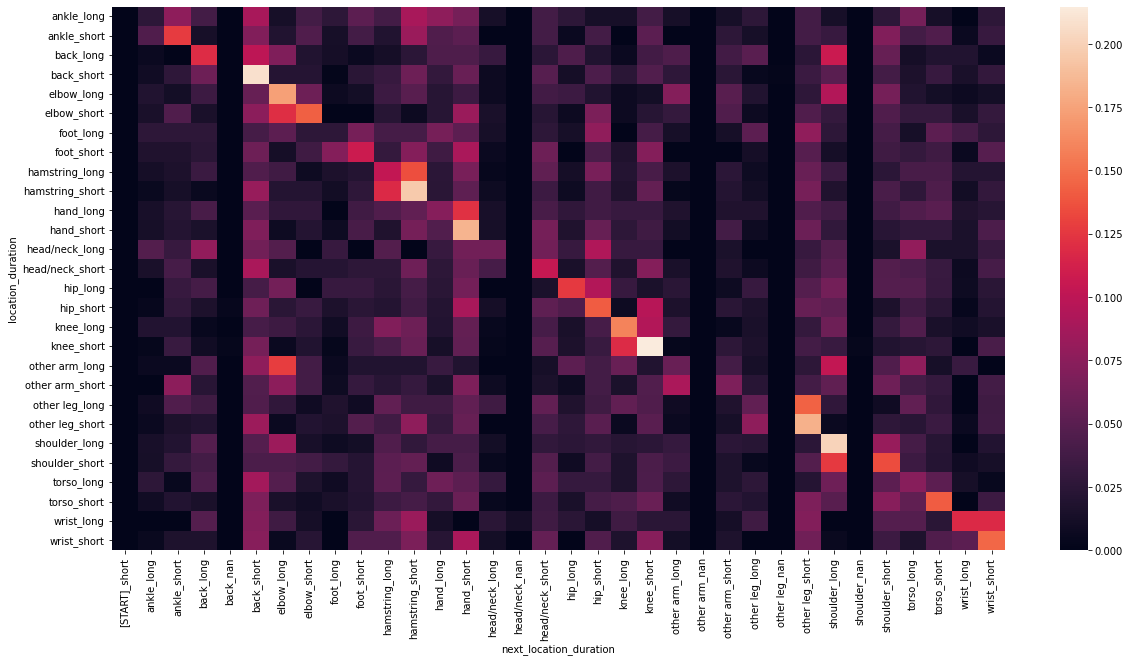

In [630]:
mat = pd.pivot_table(
    df[df.location_duration.notnull() & df.next_location_duration.notnull()]
    # .merge(qualified_players.query("size>100"))\
    .query(
        "injury_location!='[START]' and next_location!='[END]' and injury_location!='[END]'"
    )
    .groupby(["location_duration", "next_location_duration"], as_index=False)
    .size(),
    columns="next_location_duration",
    values="size",
    index="location_duration",
).fillna(0)


mat = mat.drop(
    columns=[x for x in mat.columns if "misc/unk_" in x],
    index=[x for x in mat.index if "misc/unk_" in x],
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.heatmap(mat / mat.sum(1).values.reshape(-1, 1))

In [312]:
df.query("location_duration=='hamstring_long'").next_location_duration.value_counts()

Series([], Name: next_location_duration, dtype: int64)

In [313]:
df.groupby("location_duration").filter(lambda x: len(x) > 50).location_duration.unique()

array(['[START]_nan', 'back_med', '[END]_nan', 'hand_med',
       'hamstring_med', 'shoulder_med', 'torso_med', 'hip_med',
       'back_short', 'other leg_med', 'knee_med', 'hand_long',
       'other arm_med', 'ankle_short', 'knee_long', 'other leg_short',
       'head/neck_short', 'shoulder_long', 'foot_short', 'knee_short',
       'torso_short', 'hamstring_short', 'hip_short', 'ankle_med',
       'misc/unk_med', 'elbow_long', 'shoulder_short', 'wrist_med',
       'foot_med', 'foot_long', 'wrist_short', 'misc/unk_long',
       'other arm_long', 'hand_short', 'other arm_short',
       'misc/unk_short', 'elbow_short'], dtype=object)

In [186]:
df.location_duration.value_counts()

[START]_long       6492
[END]_long         5578
back_short          444
hamstring_short     386
hand_short          380
shoulder_long       333
knee_short          324
other leg_short     300
head/neck_short     296
hamstring_long      281
hip_short           268
torso_long          250
shoulder_short      244
misc/unk_short      237
hand_long           232
elbow_long          230
torso_short         216
knee_long           206
back_long           187
wrist_short         185
misc/unk_long       172
foot_short          166
ankle_short         163
other arm_long      143
elbow_short         142
other arm_short     133
hip_long            126
other leg_long      119
ankle_long           93
wrist_long           91
foot_long            90
head/neck_long       79
Name: location_duration, dtype: int64

<AxesSubplot:>

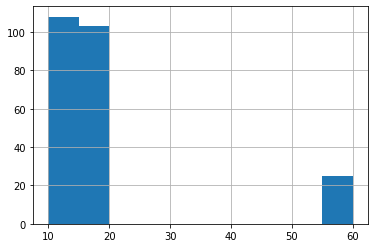

In [187]:
df.query("injury_location=='knee'").il_days.hist()

In [34]:
# # from injury.preprocess.injury_map import (
# #     alt_injury_regex,
# #     injury_cat,
# #     injury_large_cat_map,
# #     injury_priority,
# # )
# # from injury.preprocess.location_map import (
# #     alt_location_regex,
# #     location_cat,
# #     location_large_cat_map,
# #     location_priority,
# # )
# # from injury.preprocess.categorization import injury_priority_map

# df["location_len"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform(len)
# df["type_len"] = df.groupby(["player_id","injury_span_id"])["injury_type"].transform(len)
# df["test"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform(max)
# df["test_type"] = df.groupby(["player_id","injury_span_id"])["injury_type"].transform(max)
# df["mean_dtd"] = df.groupby(["player_id","injury_span_id"])["dtd"].transform(np.mean)
# df["location_same"] = df.groupby(["player_id","injury_span_id"])["injury_location"].transform("nunique")

df["location_unk"] = df.groupby(["player_id", "injury_span_id"])[
    "injury_location"
].transform(lambda x: sum(x == "misc/unk"))

In [5]:
# data[data.notes.fillna("").str.contains("retroactive to [a-z]+\s+[0-9]+\,\s+[0-9]+(\.)?$")].notes

In [17]:
# df.query(" location_len>1 and injury_notes==''").shape

In [18]:
# df.query(" location_len==1 and injury_notes==''")

In [19]:
# df.query("player_id==605483 and injury_span_id==156")

In [33]:
df[df.injury_location.notnull()].query("location_len>1 and location_same==1")[
    ["player_id", "injury_span_id"]
].drop_duplicates().shape

(876, 2)

In [35]:
df[df.injury_location.notnull()].query(
    "location_len>1 and location_same>1 and location_unk<location_same-1"
)[["player_id", "injury_span_id"]].drop_duplicates().shape

(98, 2)

In [36]:
df[df.injury_location.notnull()].query(
    "location_len>1 and location_same>1 and location_unk<location_same-1"
).sort_values(["player_id", "injury_span_id"]).head(20)

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,cum_games,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,time_since_last_game,non_mlb_days,location_len,type_len,test,test_type,mean_dtd,location_same,location_unk
1629,2012-08-22,2012-08-18,new york mets placed lhp johan santana on the ...,276371.0,121.0,2012,NYM,Mets,Johan Santana,False,False,False,inflammation of the lower back,15,inflammationmation of the lower back,inflammation,inflammation of the lower back,back,0,1.0,2012-08-22,NaT,NaN,NaN,1.0,0.0,2012-08-17,NaT,False,False,21.0,0.0,0.0,3,3,shoulder,surgery,0.0,2,0
1895,2013-03-31,2013-03-22,new york mets placed lhp johan santana on the ...,276371.0,121.0,2013,NYM,Mets,Johan Santana,False,False,False,re-tear of the anterior capsule in his left sh...,15,re-tear of the anterior capsule in his left sh...,tear/strain/sprain,re-tear of the anterior capsule in his left sh...,shoulder,0,2.0,2013-03-31,NaT,NaN,NaN,0.0,0.0,2012-08-17,NaT,False,False,21.0,0.0,0.0,3,3,shoulder,surgery,0.0,2,0
3072,2014-06-02,2014-06-02,baltimore orioles placed lhp johan santana on ...,276371.0,110.0,2014,BAL,Orioles,Johan Santana,False,False,False,recovering from april 2013 left shoulder surgery,15,recovering from april 2013 left shoulder surgery,surgery,recovering from april 2013 left shoulder surgery,shoulder,0,3.0,2014-06-02,NaT,NaN,NaN,0.0,NaN,2012-08-17,NaT,False,True,21.0,0.0,0.0,3,3,shoulder,surgery,0.0,2,0
2119,2013-05-15,2013-05-14,los angeles dodgers placed rhp josh beckett on...,277417.0,119.0,2013,LAD,Dodgers,Josh Beckett,False,False,False,strained left groin,15,strained left groin,tear/strain/sprain,strained left groin,hip,0,1.0,2013-05-15,NaT,NaN,NaN,1.0,0.0,2013-05-13,2014-04-09,False,False,36.0,0.0,0.0,2,2,hand,tear/strain/sprain,0.0,2,0
2717,2014-03-19,2014-03-19,los angeles dodgers placed rhp josh beckett on...,277417.0,119.0,2014,LAD,Dodgers,Josh Beckett,False,False,False,right thumb sprain,15,right thumb sprain,tear/strain/sprain,right hand sprain,hand,0,2.0,2014-03-19,NaT,NaN,NaN,0.0,1.0,2013-05-13,2014-04-09,False,False,36.0,0.0,0.0,2,2,hand,tear/strain/sprain,0.0,2,0
1670,2012-08-31,2012-08-31,st. louis cardinals placed ss rafael furcal on...,279577.0,138.0,2012,STL,Cardinals,Rafael Furcal,False,False,False,right elbow strain,15,right elbow strain,tear/strain/sprain,right elbow strain,elbow,0,0.0,2012-08-31,NaT,NaN,NaN,1.0,0.0,2012-08-30,2014-06-13,False,False,120.0,0.0,0.0,3,3,elbow,surgery,0.0,2,0
1845,2013-03-22,2013-03-22,st. louis cardinals placed ss rafael furcal on...,279577.0,138.0,2013,STL,Cardinals,Rafael Furcal,False,False,False,recovering from march 2013 tommy john surgery,15,recovering from march 2013 tommy john surgery,surgery,recovering from march 2013 elbow surgery,elbow,0,1.0,2013-03-22,NaT,NaN,NaN,0.0,0.0,2012-08-30,2014-06-13,False,False,120.0,0.0,0.0,3,3,elbow,surgery,0.0,2,0
2798,2014-03-30,2014-03-21,miami marlins placed 2b rafael furcal on the 1...,279577.0,146.0,2014,MIA,Marlins,Rafael Furcal,False,False,False,left hamstring discomfort,15,left hamstring discomfort,minor,left hamstring discomfort,hamstring,0,2.0,2014-03-30,NaT,NaN,NaN,0.0,1.0,2012-08-30,2014-06-13,False,False,120.0,0.0,0.0,3,3,elbow,surgery,0.0,2,0
1455,2012-07-19,2012-07-19,texas rangers placed rhp colby lewis on the 15...,407890.0,140.0,2012,TEX,Rangers,Colby Lewis,False,False,False,right forearm tendinitis,15,right forearm inflammation,inflammation,right lower arm tendinitis,other arm,0,1.0,2012-07-19,NaT,NaN,NaN,1.0,0.0,2012-07-18,2014-04-14,False,False,16.0,0.0,0.0,2,2,elbow,surgery,0.0,2,0
1877,2013-03-31,2013-03-22,texas rangers placed rhp colby lewis on the 15...,407890.0,140.0,2013,TEX,Rangers,Colby Lewis,False,False,False,recovering from july 2012 right elbow surgery,15,recovering from july 2012 

In [261]:
df[df.injury_location.notnull()].query("location_len>1").sort_values(
    ["player_id", "injury_span_id"]
)

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,cum_games,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,time_since_last_game,non_mlb_days,test,location_len
13286,2018-08-24,2018-08-21,texas rangers placed rhp bartolo colon on the ...,112526.0,140.0,2018,TEX,Rangers,Bartolo Colon,False,False,False,lower back strain,10,lower back strain,tear/strain/sprain,lower back strain,back,0,4.0,2018-08-24,NaT,NaN,NaN,1.0,0.0,2018-08-20,2018-09-05,False,False,233.0,0.0,0.0,back,2
13337,2018-09-01,NaN,stomach virus (dtd),112526.0,140.0,2018,TEX,Rangers,Bartolo Colon,True,False,False,stomach virus,NaN,internal internal,internal,stomach virus,misc/unk,0,5.0,2018-09-01,NaT,NaN,NaN,0.0,1.0,2018-08-20,2018-09-05,False,False,233.0,0.0,0.0,back,2
1657,2012-08-27,2012-08-25,boston red sox placed dh david ortiz on the 15...,120074.0,111.0,2012,BOS,Red Sox,David Ortiz,False,False,False,right achilles tendon injury,15,right achilles tendon injury,misc/unk,right ankle es tendon injury,ankle,0,1.0,2012-08-27,NaT,NaN,NaN,1.0,0.0,2012-08-24,2013-04-20,False,False,89.0,0.0,0.0,ankle,2
1913,2013-03-31,2013-03-22,boston red sox placed dh david ortiz on the 15...,120074.0,111.0,2013,BOS,Red Sox,David Ortiz,False,False,False,sore right achilles,15,soreness right achilles,minor,sore right ankle es,ankle,0,2.0,2013-03-31,NaT,NaN,NaN,0.0,1.0,2012-08-24,2013-04-20,False,False,89.0,0.0,0.0,ankle,2
10870,2017-09-01,NaN,left hamstring injury (dtd),134181.0,140.0,2017,TEX,Rangers,Adrian Beltre,True,False,False,left hamstring injury,NaN,left hamstring injury,misc/unk,left hamstring injury,hamstring,0,6.0,2017-09-01,NaT,NaN,NaN,1.0,0.0,2017-08-31,2017-09-13,False,False,886.0,0.0,0.0,hamstring,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,2021-08-06,2021-08-06,boston red sox placed 2b jarren duran on the 1...,680776.0,111.0,2021,BOS,Red Sox,Jarren Duran,False,False,False,,10,,misc/unk,,misc/unk,0,1.0,2021-08-06,NaT,NaN,NaN,0.0,1.0,2021-08-05,2021-08-08,False,False,58.0,0.0,0.0,misc/unk,2
21066,2021-09-10,NaN,sore leg (dtd),683734.0,145.0,2021,CWS,White Sox,Andrew Vaughn,True,False,False,sore leg,NaN,soreness leg,minor,sore leg,other leg,0,2.0,2021-09-10,NaT,NaN,NaN,1.0,0.0,2021-09-09,2021-09-23,False,False,156.0,0.0,0.0,back,2
21124,2021-09-14,2021-09-10,chicago white sox placed 1b andrew vaughn on t...,683734.0,145.0,2021,CWS,White Sox,Andrew Vaughn,False,False,False,lower back inflammation,10,lower back inflammationmation,inflammation,lower back inflammation,back,0,3.0,2021-09-14,NaT,NaN,NaN,0.0,1.0,2021-09-09,2021-09-23,False,False,156.0,0.0,0.0,back,2
19465,2021-05-09,2021-05-09,texas rangers placed rhp kohei arihara on the ...,685503.0,140.0,2021,TEX,Rangers,Kohei Arihara,False,False,False,right middle finger contusion,10,right middle finger contusion,contusion/bruise,right middle hand contusion,hand,0,0.0,2021-05-09,NaT,NaN,NaN,1.0,0.0,2021-05-08,2021-09-01,False,False,11.0,0.0,0.0,hand,2


In [248]:
df.test.value_counts()

misc/unk     1220
shoulder     1177
elbow         953
back          894
hand          857
hamstring     855
knee          731
torso         676
head/neck     570
other leg     565
hip           540
other arm     509
wrist         370
ankle         343
foot          326
Name: test, dtype: int64

In [245]:
df.groupby(["player_id", "injury_span_id"])[
    ["injury_location", "injury_type"]
].transform(max)

,injury_location,injury_type
0,back,surgery
1,shoulder,surgery
2,elbow,surgery
3,elbow,surgery
4,elbow,surgery
...,...,...
22253,NaN,NaN
22254,NaN,NaN
22255,NaN,NaN
22256,NaN,NaN


In [244]:
df.groupby(["player_id", "injury_span_id"]).apply(
    lambda x: (set(x["injury_location"]), set(x["test"]))
).value_counts()

({nan}, {nan})                             8204
({misc/unk}, {misc/unk})                   1174
({shoulder}, {shoulder})                    947
({back}, {back})                            777
({hamstring}, {hamstring})                  766
                                           ... 
({elbow, hamstring}, {elbow})                 1
({wrist, other arm, misc/unk}, {wrist})       1
({head/neck, other arm}, {head/neck})         1
({hand, knee}, {knee})                        1
({back, other leg}, {back})                   1
Length: 71, dtype: int64

In [198]:
# injury_large_cat_map

In [185]:
data.groupby(["player_id", "injury_span_id"]).apply(
    lambda x: set(x["injury_location"])
).value_counts().head(30)

{nan}                   14933
{misc/unk}               1139
{shoulder}                923
{hamstring}               741
{back}                    741
{hand}                    733
{elbow}                   654
{knee}                    613
{torso}                   578
{other leg}               473
{hip}                     473
{head/neck}               435
{other arm}               433
{wrist}                   308
{ankle}                   293
{foot}                    291
{elbow, misc/unk}          39
{back, nan}                36
{nan, misc/unk}            35
{nan, other leg}           34
{nan, hamstring}           25
{nan, hip}                 24
{shoulder, nan}            24
{nan, knee}                23
{nan, hand}                23
{other arm, elbow}         20
{shoulder, misc/unk}       18
{nan, elbow}               17
{nan, head/neck}           16
{nan, other arm}           15
dtype: int64

In [188]:
df.injury_type.unique()

array(['[START]', 'tear/strain/sprain', 'misc/unk', '[END]',
       'break/fracture', 'inflammation', 'contusion/bruise', 'minor',
       'surgery'], dtype=object)

<AxesSubplot:>

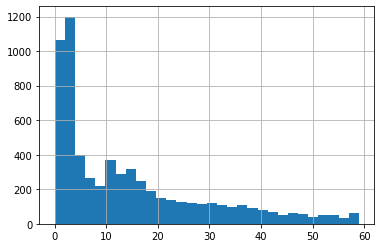

In [166]:
df[df.in_season_duration < 60].in_season_duration.hist(bins=30)

In [161]:
df.query("player_id==458924").sort_values("date")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,cum_games,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,time_since_last_game,non_mlb_days,start_date,prev_injury_end_date,t_actual,cum_season_days,prev_season_days,next_game_season_days,prev_non_mlb_days,dt,in_season_duration,duration,t,dt_
873,2012-04-05,NaN,NaN,458924.0,NaN,2012,ATL,NaN,Jonny Venters,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2012-04-05,R,1.0,NaN,1.0,NaT,NaT,True,False,39.0,0.0,0.0,2012-04-05,2012-04-05,0,9,9,NaN,0.0,0.0,NaN,NaN,0.0,0
988,2012-07-05,2012-07-05,atlanta braves placed lhp jonny venters on the...,458924.0,144.0,2012,ATL,Braves,Jonny Venters,False,False,False,left elbow impingement,15,left elbow impingement,inflammation,left elbow impingement,elbow,0,0.0,2012-07-05,NaT,NaN,NaN,1.0,1.0,2012-07-04,2012-07-22,False,False,40.0,0.0,0.0,2012-04-05,2012-04-05,91,100,9,117.0,0.0,91.0,17.0,17.0,91.0,91
9183,2014-03-23,2014-03-21,atlanta braves placed lhp jonny venters on the...,458924.0,144.0,2014,ATL,Braves,Jonny Venters,False,False,False,recovering from may 2013 tommy john surgery,15,recovering from may 2013 tommy john surgery,surgery,recovering from may 2013 elbow surgery,elbow,0,2.0,2014-03-23,NaT,NaN,NaN,0.0,1.0,2012-10-03,2018-02-25,False,False,66.0,0.0,0.0,2012-04-05,2012-07-21,717,376,116,1310.0,0.0,260.0,934.0,1435.0,351.0,260
6929,2018-06-25,2018-06-25,tampa bay rays placed lhp jonny venters on the...,458924.0,139.0,2018,TB,Rays,Jonny Venters,False,False,False,right hamstring strain,10,right hamstring strain,tear/strain/sprain,right hamstring strain,hamstring,0,3.0,2018-06-25,NaT,NaN,NaN,1.0,1.0,2018-06-24,2018-07-25,False,False,95.0,0.0,0.0,2012-04-05,2018-02-24,2272,1430,1309,1460.0,0.0,121.0,30.0,30.0,472.0,121
342,2019-04-15,2019-04-15,atlanta braves placed lhp jonny venters on the...,458924.0,144.0,2019,ATL,Braves,Jonny Venters,False,False,False,calf strain,10,calf strain,tear/strain/sprain,calf strain,other leg,0,4.0,2019-04-15,NaT,NaN,NaN,1.0,1.0,2019-04-14,2019-05-11,False,False,140.0,0.0,0.0,2012-04-05,2018-07-24,2566,1608,1459,1634.0,0.0,149.0,26.0,26.0,621.0,149
8662,2019-07-11,2019-07-08,washington nationals placed lhp jonny venters ...,458924.0,120.0,2019,WSH,Nationals,Jonny Venters,False,False,False,"retroactive to july 8, 2019",10,"retroactive to july 8, 2019",misc/unk,"retroactive to july 8, 2019",misc/unk,0,5.0,2019-07-11,NaT,NaN,NaN,1.0,NaN,2019-07-05,NaT,False,True,146.0,0.0,0.0,2012-04-05,2019-05-10,2653,1695,1633,NaN,0.0,62.0,NaN,NaN,683.0,62


In [24]:
df.to_parquet("injury_final.parquet")

In [13]:
df.groupby(["player_id", "name"], as_index=False)[
    ["injury_type", "injury_location", "dt"]
].agg(list).to_parquet("seq.parquet")

In [86]:
data.query("player_id==668881 and date>'2017-05-01'")

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,cum_games,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,time_since_last_game,non_mlb_days
787944,2021-03-02,NaN,NaN,668881.0,NaN,2021,CIN,NaN,"Greene, Hunter",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaT,2021-03-02,S,1.0,NaN,NaN,NaT,NaT,True,True,1548.0,0.0,0.0


In [101]:
players.query("game_type=='R' and game_date>'2014-03-19'").sort_values("game_date")

,player_id,name,game_date,game_type,team,date,year,game,cum_games
158194,453198,"Perez, Chris",2014-03-22,R,LAD,2014-03-22,2014,1,116
245593,471083,"Montero, Miguel",2014-03-22,R,ARI,2014-03-22,2014,1,258
194789,457759,"Turner, Justin",2014-03-22,R,LAD,2014-03-22,2014,1,174
169678,454560,"Ellis, A.J.",2014-03-22,R,LAD,2014-03-22,2014,1,246
689858,624577,"Puig, Yasiel",2014-03-22,R,LAD,2014-03-22,2014,1,103
...,...,...,...,...,...,...,...,...,...
688938,624428,"Frazier, Adam",2021-10-03,R,SD,2021-10-03,2021,1,741
310331,502054,"Pham, Tommy",2021-10-03,R,SD,2021-10-03,2021,1,829
788723,677551,"Franco, Wander",2021-10-03,R,TB,2021-10-03,2021,1,89
445827,543768,"Shaw, Travis",2021-10-03,R,BOS,2021-10-03,2021,1,840


In [108]:
# data.query("player_id==542888 and date>'2019-03-01'")

In [157]:
df

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,cum_games,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,time_since_last_game,non_mlb_days,start_date,prev_injury_end_date,t_actual,cum_season_days,prev_season_days,next_game_season_days,prev_non_mlb_days,dt,in_season_duration,duration,t,dt_
0,2012-04-07,NaN,NaN,110029.0,NaN,2012,LAA,NaN,"Abreu, Bobby",NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2012-04-07,R,1.0,NaN,1.0,NaT,NaT,True,False,1548.0,0.0,74.0,2012-04-07,2012-04-07,0,11,11,NaN,0.0,0.0,NaN,NaN,0.0,0
174,2012-03-29,NaN,NaN,112526.0,NaN,2012,OAK,NaN,Bartolo Colon,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2012-03-29,R,1.0,NaN,1.0,NaT,NaT,True,False,14.0,0.0,0.0,2012-03-29,2012-03-29,0,2,2,NaN,0.0,0.0,NaN,NaN,0.0,0
182,2012-06-23,2012-06-18,oakland athletics placed rhp bartolo colon on ...,112526.0,133.0,2012,OAK,Athletics,Bartolo Colon,False,False,False,strained right oblique,15,strained right oblique,tear/strain/sprain,strained right oblique ique,torso,0,0.0,2012-06-23,NaT,NaN,NaN,1.0,1.0,2012-06-17,2012-07-03,False,False,15.0,0.0,0.0,2012-03-29,2012-03-29,86,88,2,98.0,0.0,86.0,10.0,10.0,86.0,86
270,2013-08-17,2013-08-14,oakland athletics placed rhp bartolo colon on ...,112526.0,133.0,2013,OAK,Athletics,Bartolo Colon,False,False,False,left groin strain,15,left groin strain,tear/strain/sprain,left groin strain,hip,0,1.0,2013-08-17,NaT,NaN,NaN,1.0,1.0,2013-08-13,2013-08-29,False,False,48.0,0.0,0.0,2012-03-29,2012-07-02,506,330,97,342.0,0.0,233.0,12.0,12.0,319.0,233
283,2017-06-06,2017-06-06,atlanta braves placed rhp bartolo colon on the...,112526.0,144.0,2017,ATL,Braves,Bartolo Colon,False,False,False,left oblique strain,10,left oblique strain,tear/strain/sprain,left oblique ique strain,torso,0,2.0,2017-06-06,NaT,NaN,NaN,1.0,1.0,2017-06-05,2017-06-28,False,False,187.0,0.0,0.0,2012-03-29,2013-08-28,1895,1159,341,1181.0,0.0,818.0,22.0,22.0,1137.0,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,2021-10-03,NaN,NaN,680777.0,NaN,2021,MIN,NaN,Ryan Jeffers,NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-10-03,R,131.0,1.0,NaN,NaT,NaT,False,True,1548.0,2.0,0.0,2019-02-26,2021-07-17,950,2274,2196,NaN,0.0,78.0,NaN,NaN,515.0,78
8716,2020-02-24,NaN,NaN,683734.0,NaN,2020,CWS,NaN,Andrew Vaughn,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2020-02-24,S,1.0,NaN,1.0,NaT,NaT,True,False,78.0,0.0,131.0,2020-02-24,2020-02-24,0,1810,1810,NaN,0.0,0.0,NaN,NaN,0.0,0
6374,2021-06-03,2021-06-03,chicago white sox placed 1b andrew vaughn on t...,683734.0,145.0,2021,CWS,White Sox,Andrew Vaughn,False,False,False,,10,,misc/unk,,misc/unk,0,1.0,2021-06-03,NaT,NaN,NaN,1.0,1.0,2021-06-01,2021-06-05,False,False,80.0,0.0,0.0,2020-02-24,2021-05-31,465,2152,2149,2154.0,0.0,3.0,2.0,2.0,211.0,3
10055,2021-09-14,2021-09-10,chicago white sox placed 1b andrew vaughn on t...,683734.0,145.0,2021,CWS,White Sox,Andrew Vaughn,False,False,False,lower back inflammation,10,lower back inflammationmation,inflammation,lower back inflammation,back,0,3.0,2021-09-14,NaT,NaN,NaN,0.0,1.0,2021-09-09,2021-09-23,False,False,156.0,0.0,0.0,2020-02-24,2021-06-04,568,2255,2153,2264.0,0.0,102.0,9.0,9.0,313.0,102


In [42]:
# location = df["injury_location"]
df["next_location"] = df.groupby("player_id")["injury_location"].shift(-1)

In [59]:
pairs = (
    df.groupby(["injury_location", "next_location"])["dt"]
    .agg({"count", "mean", "median"})
    .reset_index()
)

In [64]:
# pairs

In [61]:
cond = (
    pairs["injury_location"].notnull()
    & pairs["next_location"].notnull()
    & ~pairs["injury_location"].isin(["[START]", "[END]"])
    & ~pairs["next_location"].isin(["[START]", "[END]"])
)

pairs = pairs[cond]

In [76]:
pairs.query("injury_location=='foot'")

,injury_location,next_location,median,count,mean
65,foot,ankle,38.0,9,134.666667
66,foot,back,82.0,19,173.210526
67,foot,elbow,88.0,12,147.583333
68,foot,foot,108.5,36,132.138889
69,foot,hamstring,154.0,23,246.826087
70,foot,hand,80.0,28,118.964286
71,foot,head/neck,137.0,13,169.076923
72,foot,hip,48.5,14,236.071429
73,foot,knee,63.5,16,87.812500
74,foot,misc/unk,106.5,6,129.833333


In [65]:
pairs.sort_values("count", ascending=False).head(20)

,injury_location,next_location,median,count,mean
85,hamstring,hamstring,78.0,169,154.798817
221,shoulder,shoulder,166.5,148,254.716216
153,knee,knee,78.0,143,164.650350
34,back,back,93.0,136,188.566176
102,hand,hand,111.0,119,207.605042
51,elbow,elbow,177.5,94,245.127660
204,other leg,other leg,39.0,90,132.888889
136,hip,hip,112.0,65,195.815385
238,torso,torso,102.0,63,185.904762
45,back,shoulder,128.0,56,221.535714


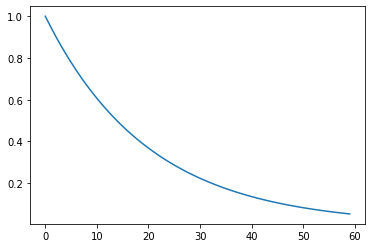

In [73]:
import matplotlib.pyplot as plt

plt.plot(np.exp(-0.05 * np.arange(60)))

In [50]:
# df["injury_duration"] = (df.groupby("player_id")["date"].shift(-1) - df["injury_date"]).dt.days

# df["dt_injury_span_start"] = (df["injury_date"]-
#                           df.groupby(["player_id","injury_span_id"])
#                           ["injury_date"].transform("min")).dt.days


# df["prev_injury_end_date"] = df.groupby("player_id")["next_game_date"].shift(1) - pd.Timedelta(1, "days")
# df["prev_injury_end_date"] = df.groupby("player_id")["prev_injury_end_date"].ffill()
# df["prev_injury_end_date_span"] = df.groupby(["player_id", "injury_span_id"])["prev_injury_end_date"].transform("nth",0)

In [51]:
# df.groupby(["player_id","injury_span_id"]).agg(
#     count = ("injury_location", "count"),
#     unique = ("injury_location","nunique"),
#     unique_not_misc = ("injury_location", lambda x: len(np.unique([i for i in x if i!='misc/unk']))),
#     injury_span = ("dt_injury_span_start", "max"),
#     injury_duration = ("injury_duration", "max")
# ).reset_index().sort_values("count").query("unique_not_misc>1")#.tail(50)

In [52]:
# pd.read_pickle("injuries2012-2021.pkl").date.min()

In [53]:
df.query("player_id==545361")[
    ["notes", "date", "injury_type", "injury_location", "dt", "in_season_duration"]
]

,notes,date,injury_type,injury_location,dt,in_season_duration


In [78]:
x = pd.cut(df.duration, [0, 10, 30, np.inf])

In [91]:
x.categories = ["short", "med", "long"]

In [75]:
pd.cut(df.in_season_duration, [0, 10, 30, np.inf], right=True).value_counts()

(0.0, 10.0]     3263
(30.0, inf]     1601
(10.0, 30.0]    1501
Name: in_season_duration, dtype: int64

In [ ]:
df.groupby(["player_id", "name"], as_index=False)[
    ["injury_type", "injury_location", "dt"]
].agg(list).sample(10)

In [54]:
df["row"] = df.groupby("player_id").cumcount()
atleast1_injury = df.groupby("player_id").filter(lambda x: sum(x["game"] == 0) > 0)[
    ["player_id"]
]

<AxesSubplot:xlabel='row'>

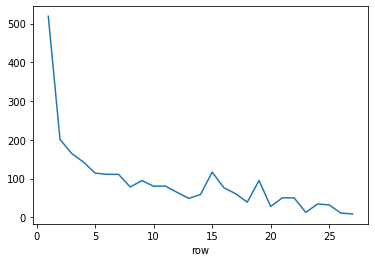

In [55]:
df.merge(atleast1_injury).query("row>0 and injury_type!='[END]'").groupby("row").dt.agg(
    {"mean", "count"}
)["mean"].plot()

<AxesSubplot:>

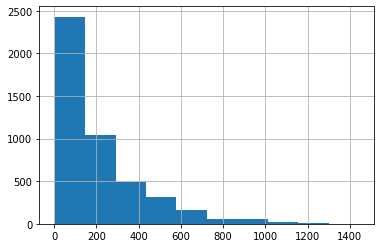

In [58]:
df.merge(atleast1_injury).query("row==2 and injury_type!='[END]'").dt.hist()

In [1657]:
df.sort_values("dt", ascending=False)

,date,effectiveDate,notes,player_id,team_id,year,team,team_name,name,dtd,activated,transfer,injury_notes,il_days,injury_type_notes,injury_type,injury_location_notes,injury_location,game,injury_id,injury_date,game_date,game_type,prev_is_game,next_is_game,prev_game_date,next_game_date,player_first_row,player_last_row,injury_span_id,start_date,prev_injury_end_date,t,cum_season_days,prev_season_days,next_game_season_days,dt,in_season_duration,duration,row
467,2021-10-01,NaN,NaN,472551.0,NaN,2021,BAL,NaN,"Abad, Fernando",NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-10-01,R,1.0,NaN,NaT,NaT,False,True,-390,2012-04-06,2012-04-06,3465,2272,10,NaN,2262,NaN,NaN,1
145,2021-10-02,NaN,NaN,476595.0,NaN,2021,NYY,NaN,"Luetge, Lucas",NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-10-02,R,1.0,NaN,NaT,NaT,False,True,-207,2012-04-07,2012-04-07,3465,2273,11,NaN,2262,NaN,NaN,1
501,2021-09-30,NaN,NaN,571521.0,NaN,2021,CHC,NaN,"Brothers, Rex",NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-09-30,R,1.0,NaN,NaT,NaT,False,True,-370,2012-04-06,2012-04-06,3464,2271,10,NaN,2261,NaN,NaN,1
1316,2021-10-03,NaN,NaN,453268.0,NaN,2021,COL,NaN,"Bard, Daniel",NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-10-03,R,1.0,NaN,NaT,NaT,False,True,-125,2012-04-10,2012-04-10,3463,2274,14,NaN,2260,NaN,NaN,1
3225,2021-10-03,NaN,NaN,571800.0,NaN,2021,DET,NaN,"Hutchison, Drew",NaN,NaN,NaN,NaN,NaN,NaN,[END],NaN,[END],1,NaN,NaT,2021-10-03,R,1.0,NaN,NaT,NaT,False,True,-139,2012-04-21,2012-04-21,3452,2274,25,NaN,2249,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2015-03-05,NaN,NaN,543768.0,NaN,2015,BOS,NaN,Travis Shaw,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2015-03-05,S,NaN,1.0,NaT,NaT,True,False,-1,2015-03-05,2015-03-05,0,568,568,NaN,0,NaN,NaN,0
4526,2013-04-01,NaN,NaN,543776.0,NaN,2013,LAA,NaN,JB Shuck,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2013-04-01,R,NaN,1.0,NaT,NaT,True,False,-1,2013-04-01,2013-04-01,0,192,192,NaN,0,NaN,NaN,0
5597,2013-06-06,NaN,NaN,543779.0,NaN,2013,STL,NaN,Kevin Siegrist,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2013-06-06,R,NaN,1.0,NaT,NaT,True,False,-1,2013-06-06,2013-06-06,0,258,258,NaN,0,NaN,NaN,0
9720,2014-04-16,NaN,NaN,543807.0,NaN,2014,HOU,NaN,George Springer,NaN,NaN,NaN,NaN,NaN,NaN,[START],NaN,[START],1,NaN,NaT,2014-04-16,R,NaN,1.0,NaT,NaT,True,False,-1,2014-04-16,2014-04-16,0,400,400,NaN,0,NaN,NaN,0
